Im going to follow the same approach most of the notebooks I've seen here. I'll see what they are trying to do and their approach. Maybe learn a couple of things and improve on that.

In [5]:
# Imports

import glob             # file pattern matching
import numpy as np        # numerical operations
import pandas as pd         # data manipulation

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning using scikit-learn for model training and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, brier_score_loss, mean_squared_error, roc_curve, auc
from sklearn.ensemble import RandomForestRegressor
from sklearn.isotonic import IsotonicRegression  # For probability calibration
from xgboost import XGBRegressor


## Data loading
Most notebooks appear to be concatenating all the notebooks into a single csv.

In [6]:
data_path = "/home/dalducin/GITHUB/KAGGLE/march_madness_2025/data/**"

In [7]:
files = glob.glob(data_path)
data = {p.split('/')[-1].split('.')[0]: pd.read_csv(p, encoding='latin-1') for p in files}

## Merging Data
Concatenate the mens and womens teams and their spellings then merge into a single dataframe of teams.

The `teams` dataframe was created by concatenating men's and women's team data and merging with team spellings. 

The `games` dataframe was created by combining detailed season and tournament results, adding game statistics, and mapping seeds. 

The `sub` dataframe was created by adding game states and merging aggregated statistics into the submission data.

In [8]:
# Combine men's and women's team data into one DataFrame
teams = pd.concat([data['MTeams'], data['WTeams']])

# Combine team spellings for consistency
teams_spelling = pd.concat([data['MTeamSpellings'], data['WTeamSpellings']])

# Group by TeamID and count occurrences of team name spellings (could be used as a quality metric)
teams_spelling = teams_spelling.groupby(by='TeamID', as_index=False)['TeamNameSpelling'].count()
teams_spelling.columns = ['TeamID', 'TeamNameCount']

# Merge the teams data with the spellings count
teams = pd.merge(teams, teams_spelling, how='left', on=['TeamID'])
teams

,TeamID,TeamName,FirstD1Season,LastD1Season,TeamNameCount
0,1101,Abilene Chr,2014.0,2025.0,3
1,1102,Air Force,1985.0,2025.0,2
2,1103,Akron,1985.0,2025.0,1
3,1104,Alabama,1985.0,2025.0,1
4,1105,Alabama A&M,2000.0,2025.0,2
...,...,...,...,...,...
753,3476,Stonehill,NaN,NaN,1
754,3477,East Texas A&M,NaN,NaN,3
755,3478,Le Moyne,NaN,NaN,1
756,3479,Mercyhurst,NaN,NaN,1


In [9]:
# Concatenates men's and women's regular season and NCAA tournament for compact and detailed results.
season_cresults = pd.concat([data['MRegularSeasonCompactResults'], data['WRegularSeasonCompactResults']])
season_dresults = pd.concat([data['MRegularSeasonDetailedResults'], data['WRegularSeasonDetailedResults']])
tourney_cresults = pd.concat([data['MNCAATourneyCompactResults'], data['WNCAATourneyCompactResults']])
tourney_dresults = pd.concat([data['MNCAATourneyDetailedResults'], data['WNCAATourneyDetailedResults']])


In [10]:
# Create a seeds data frame with the mens and womens seeds
# and then create a dictionary of seeds
# The dictionary is indexed by the season and team id
seeds_df = pd.concat([data['MNCAATourneySeeds'], data['WNCAATourneySeeds']])
seeds = {'_'.join(map(str, [int(k1), k2])): int(v[1:3]) for k1, v, k2 in seeds_df[['Season', 'Seed', 'TeamID']].values}
seeds

{'1985_1207': 1,
 '1985_1210': 2,
 '1985_1228': 3,
 '1985_1260': 4,
 '1985_1374': 5,
 '1985_1208': 6,
 '1985_1393': 7,
 '1985_1396': 8,
 '1985_1439': 9,
 '1985_1177': 10,
 '1985_1455': 11,
 '1985_1330': 12,
 '1985_1233': 13,
 '1985_1318': 14,
 '1985_1273': 15,
 '1985_1250': 16,
 '1985_1385': 1,
 '1985_1433': 2,
 '1985_1301': 3,
 '1985_1424': 4,
 '1985_1449': 5,
 '1985_1409': 6,
 '1985_1104': 7,
 '1985_1234': 8,
 '1985_1116': 9,
 '1985_1112': 10,
 '1985_1431': 11,
 '1985_1246': 12,
 '1985_1361': 13,
 '1985_1305': 14,
 '1985_1267': 15,
 '1985_1380': 16,
 '1985_1328': 1,
 '1985_1272': 2,
 '1985_1181': 3,
 '1985_1326': 4,
 '1985_1256': 5,
 '1985_1403': 6,
 '1985_1412': 7,
 '1985_1425': 8,
 '1985_1229': 9,
 '1985_1277': 10,
 '1985_1130': 11,
 '1985_1338': 12,
 '1985_1235': 13,
 '1985_1337': 14,
 '1985_1335': 15,
 '1985_1299': 16,
 '1985_1276': 1,
 '1985_1314': 2,
 '1985_1242': 3,
 '1985_1261': 4,
 '1985_1268': 5,
 '1985_1345': 6,
 '1985_1323': 7,
 '1985_1437': 8,
 '1985_1173': 9,
 '1985_133

In [11]:
# Create a submission column into the data
sub = data['SampleSubmissionStage1']

In [12]:
# Shorten the categories names
season_cresults['ST'] = 'S'
season_dresults['ST'] = 'S'
tourney_cresults['ST'] = 'T'
tourney_dresults['ST'] = 'T'

In [13]:
# create a games dataframe
games = pd.concat((season_dresults, tourney_dresults), axis=0, ignore_index=True)
games['WLoc'] = games['WLoc'].map({'A': 1, 'H': 2, 'N': 3})

In [14]:
# Create a new column for all the games statistics and diffs
# Create unique IDs for each game and extract team identifiers
# ID is created by concatenating Season and the sorted team IDs
games['ID'] = games.apply(lambda r: '_'.join(map(str, [r['Season']] + sorted([r['WTeamID'], r['LTeamID']]))), axis=1)

# Create an ID based solely on team IDs (regardless of season)
games['IDTeams'] = games.apply(lambda r: '_'.join(map(str, sorted([r['WTeamID'], r['LTeamID']]))), axis=1)

# Define Team1 as the team with the lower team ID and Team2 as the other team
games['Team1'] = games.apply(lambda r: sorted([r['WTeamID'], r['LTeamID']])[0], axis=1)
games['Team2'] = games.apply(lambda r: sorted([r['WTeamID'], r['LTeamID']])[1], axis=1)

# Create IDs that include season information for each team (for mapping seeds)
games['IDTeam1'] = games.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1']])), axis=1)
games['IDTeam2'] = games.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team2']])), axis=1)

# Map seeds to teams using the precomputed dictionary; if missing, fill with 0
games['Team1Seed'] = games['IDTeam1'].map(seeds).fillna(0)
games['Team2Seed'] = games['IDTeam2'].map(seeds).fillna(0)

# Create extra statistics columns for the games score difference, prediction, normalized score difference, and seed difference
games['ScoreDiff'] = games['WScore'] - games['LScore']

# Binary indicator for whether the team with the lower TeamID (Team1) won the game
games['Pred'] = games.apply(lambda r: 1.0 if sorted([r['WTeamID'], r['LTeamID']])[0] == r['WTeamID'] else 0.0, axis=1)

# Normalize the score difference based on the prediction
# If Pred is 0.0, multiply ScoreDiff by -1
games['ScoreDiffNorm'] = games.apply(lambda r: r['ScoreDiff'] * -1 if r['Pred'] == 0.0 else r['ScoreDiff'], axis=1)

# This ensures that the score difference is always positive for the winning team
games['SeedDiff'] = games['Team1Seed'] - games['Team2Seed']

# Fill missing values with -1
games = games.fillna(-1)

In [15]:
# create aggregated statistics
c_score_col = ['NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']
c_score_agg = ['sum', 'mean', 'median', 'max', 'min', 'std', 'skew', 'nunique']

# Group by team pairing (IDTeams) and aggregate the statistics
gb = games.groupby(by=['IDTeams']).agg({k: c_score_agg for k in c_score_col}).reset_index()
gb.columns = [''.join(c) + '_c_score' for c in gb.columns]

In [16]:
# select the tourney games
tourney_games = games[games['ST'] == 'T']

In [17]:
# add the game states to the submission dataframe
sub['WLoc'] = 3
sub['Season'] = sub['ID'].map(lambda x: x.split('_')[0]).astype(int)
sub['Team1'] = sub['ID'].map(lambda x: x.split('_')[1])
sub['Team2'] = sub['ID'].map(lambda x: x.split('_')[2])
sub['IDTeams'] = sub.apply(lambda r: '_'.join(map(str, [r['Team1'], r['Team2']])), axis=1)
sub['IDTeam1'] = sub.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1']])), axis=1)
sub['IDTeam2'] = sub.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team2']])), axis=1)
sub['Team1Seed'] = sub['IDTeam1'].map(seeds).fillna(0)
sub['Team2Seed'] = sub['IDTeam2'].map(seeds).fillna(0)
sub['SeedDiff'] = sub['Team1Seed'] - sub['Team2Seed']
sub = sub.fillna(-1)

In [18]:
# merge the aggregated statistics into the games and submission dataframes
games = pd.merge(games, gb, how='left', left_on='IDTeams', right_on='IDTeams_c_score')
sub = pd.merge(sub, gb, how='left', left_on='IDTeams', right_on='IDTeams_c_score')


In [19]:
games

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LBlkskew_c_score,LBlknunique_c_score,LPFsum_c_score,LPFmean_c_score,LPFmedian_c_score,LPFmax_c_score,LPFmin_c_score,LPFstd_c_score,LPFskew_c_score,LPFnunique_c_score
0,2003,10,1104,68,1328,62,3,0,27,58,...,6.153557e-01,3,153,19.125000,19.0,23,15,2.642374,0.006775,6
1,2003,10,1272,70,1393,63,3,0,26,62,...,-2.751920e-16,4,80,20.000000,20.0,24,16,3.265986,0.000000,3
2,2003,11,1266,73,1437,61,3,0,24,58,...,2.286088e-01,6,802,19.560976,20.0,28,7,5.104159,-0.421778,19
3,2003,11,1296,56,1457,50,3,0,18,38,...,1.732051e+00,2,63,21.000000,22.0,23,18,2.645751,-1.457863,3
4,2003,11,1400,77,1208,71,3,0,30,61,...,2.751920e-16,4,78,19.500000,21.0,22,14,3.785939,-1.658524,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202028,2024,147,3163,80,3425,73,1,0,28,58,...,NaN,2,32,16.000000,16.0,20,12,5.656854,NaN,2
202029,2024,147,3234,94,3261,87,2,0,32,69,...,NaN,2,40,20.000000,20.0,21,19,1.414214,NaN,2
202030,2024,151,3234,71,3163,69,3,0,27,59,...,1.732051e+00,2,35,11.666667,10.0,18,7,5.686241,1.205659,3
202031,2024,151,3376,78,3301,59,3,0,33,66,...,1.901981e-01,7,104,14.857143,15.0,22,8,5.014265,-0.159771,6


In [20]:
sub

,ID,Pred,WLoc,Season,Team1,Team2,IDTeams,IDTeam1,IDTeam2,Team1Seed,...,LBlkskew_c_score,LBlknunique_c_score,LPFsum_c_score,LPFmean_c_score,LPFmedian_c_score,LPFmax_c_score,LPFmin_c_score,LPFstd_c_score,LPFskew_c_score,LPFnunique_c_score
0,2021_1101_1102,0.5,3,2021,1101,1102,1101_1102,2021_1101,2021_1102,14.0,...,NaN,1.0,14.0,14.0,14.0,14.0,14.0,NaN,NaN,1.0
1,2021_1101_1103,0.5,3,2021,1101,1103,1101_1103,2021_1101,2021_1103,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021_1101_1104,0.5,3,2021,1101,1104,1101_1104,2021_1101,2021_1104,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021_1101_1105,0.5,3,2021,1101,1105,1101_1105,2021_1101,2021_1105,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021_1101_1106,0.5,3,2021,1101,1106,1101_1106,2021_1101,2021_1106,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507103,2024_3475_3477,0.5,3,2024,3475,3477,3475_3477,2024_3475,2024_3477,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
507104,2024_3475_3478,0.5,3,2024,3475,3478,3475_3478,2024_3475,2024_3478,0.0,...,NaN,1.0,8.0,8.0,8.0,8.0,8.0,NaN,NaN,1.0
507105,2024_3476_3477,0.5,3,2024,3476,3477,3476_3477,2024_3476,2024_3477,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
507106,2024_3476_3478,0.5,3,2024,3476,3478,3476_3478,2024_3476,2024_3478,0.0,...,1.360828,3.0,68.0,13.6,14.0,19.0,8.0,4.037326,-0.123085,5.0


In [21]:
# exclude the columns that are not needed
# and create a list of columns to be used
exclude_cols = ['ID', 'DayNum', 'ST', 'Team1', 'Team2', 'IDTeams', 'IDTeam1', 'IDTeam2', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'NumOT', 'Pred', 'ScoreDiff', 'ScoreDiffNorm', 'WLoc'] + c_score_col
col = [c for c in games.columns if c not in exclude_cols]
print("Data loading and preprocessing completed.")

Data loading and preprocessing completed.


# Training

In [22]:
# Imputer: Fill missing values with the mean of each column
imputer= SimpleImputer(strategy='mean')

# StandardScaler: Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()


In [23]:
# Get the dataframes for training
X = games[col].fillna(-1)
X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

# Get the target variable
y = games['Pred']

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Models to test

1. Random Forest Regressor
2. Isotonic Regression
3. XGBREgressor

## Metrics to check
1. Log loss
2. Brier Score
3. MSE

Following are util functions to check metrics on training and predictions.

In [25]:
def plot_feature_importance(importances, feature_names, top_n=20):
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(top_n)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
        plt.title('Top {} Feature Importances'.format(top_n))
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

In [26]:
def plot_calibration_curve(y_true, y_proba, n_bins=10):

        combined = np.stack([y_proba, y_true], axis=-1)
        combined = combined[np.argsort(combined[:, 0])]
        sorted_probas = combined[:, 0]
        sorted_true = combined[:, 1]

        bins = np.linspace(0, 1, n_bins + 1)
        bin_midpoints = bins[:-1] + (bins[1] - bins[0]) / 2
        bin_assignments = np.digitize(sorted_probas, bins) - 1

        bin_sums = np.bincount(bin_assignments, weights=sorted_probas, minlength=n_bins)
        bin_true = np.bincount(bin_assignments, weights=sorted_true, minlength=n_bins)
        bin_total = np.bincount(bin_assignments, minlength=n_bins)

        fraction_of_positives = bin_true / bin_total
        fraction_of_positives[np.isnan(fraction_of_positives)] = 0

        plt.figure(figsize=(8, 6))
        plt.plot(bin_midpoints, fraction_of_positives, marker='o', label='Calibration Curve')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

        plt.xlabel('Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title('Calibration Curve')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [27]:
def plot_prediction_distribution(predictions, title="Distribution of Predictions"):
        """Plots the distribution of model predictions."""
        plt.figure(figsize=(8, 6))
        sns.histplot(predictions, kde=True, color='skyblue')
        plt.title(title)
        plt.xlabel('Predicted Probability')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

In [28]:
def plot_roc_curve(y_true, y_proba, title="ROC Curve"):
      """Plots the Receiver Operating Characteristic (ROC) curve."""
      fpr, tpr, thresholds = roc_curve(y_true, y_proba)
      roc_auc = auc(fpr, tpr)

      plt.figure(figsize=(8, 6))
      plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
      plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(title)
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.legend(loc="lower right")
      plt.tight_layout()
      plt.show()

In [29]:
def train_model(model, X_train, X_cal, y_train, y_cal):
    """Trains a model on the training data."""
    model.fit(X_train, y_train)
    
    train_preds = model.predict(X_train).clip(0.001, 0.999)
    cal_preds = model.predict(X_cal).clip(0.001, 0.999)

    calibration_model = IsotonicRegression(out_of_bounds='clip')

    calibration_model.fit(train_preds.reshape(-1, 1), y_train)
    
    train_preds_calibrated = calibration_model.predict(train_preds.reshape(-1, 1)).clip(0.001, 0.999)

    # print the metrics
    print(f'Log Loss: {log_loss(y_train, train_preds_calibrated):.4f}')
    print(f'Brier Score Loss: {brier_score_loss(y_train, train_preds_calibrated):.4f}')
    print(f'Mean Squared Error: {mean_squared_error(y_train, train_preds_calibrated):.4f}')

    # Plot the ROC curve
    plot_roc_curve(y_cal, cal_preds, title="ROC Curve (Training)")

    # K-Fold Cross Validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_mse_scores = []
    cv_log_loss_scores = []

    for train_idx, val_idx in kfold.split(X_scaled):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        val_preds = model.predict(X_val).clip(0.001, 0.999)

        calibration_model.fit(val_preds.reshape(-1, 1), y_val)
        val_preds = model.predict(X_val).clip(0.001, 0.999)

        cv_mse_scores.append(mean_squared_error(y_val, val_preds))
        cv_log_loss_scores.append(log_loss(y_val, val_preds))
    
    print(f'Cross-Validation Mean Squared Error: {np.mean(cv_mse_scores):.4f}')
    print(f'Cross-Validation Log Loss: {np.mean(cv_log_loss_scores):.4f}')

    feature_importances = model.feature_importances_
    feature_names = X.columns
    plot_feature_importance(feature_importances, feature_names)
    plot_calibration_curve(y_cal, cal_preds)

    plot_prediction_distribution(train_preds_calibrated, title="Distribution of Predictions (Training)")
    return model, calibration_model

In [30]:
def predict_submission(model, calibration_model, sub, sub_name='submission.csv'):
    sub_X = sub[col].fillna(-1)
    sub_X_imputed = imputer.transform(sub_X)
    sub_X_scaled = scaler.transform(sub_X_imputed)

    preds = model.predict(sub_X_scaled).clip(0.001, 0.999)
    preds_calibrated = calibration_model.predict(preds.reshape(-1, 1)).clip(0.001, 0.999)

    sub['Pred'] = preds_calibrated
    sub[['ID', 'Pred']].to_csv(sub_name, index=False)
    print(f"Submission file saved to {sub_name}")

## Random Forest Regressor


In [31]:
model_RFR = RandomForestRegressor(
    n_estimators=235,       # number of trees in the forest
    random_state=42,        # random seed for reproducibility
    max_depth=15,           # limit the depth of the tree to reduce overfitting
    min_samples_split=2,    # minimum number of samples required to split an internal node
    max_features='sqrt',    # number of features to consider when looking for the best split
    n_jobs=-1               # use all available CPU cores
)

Log Loss: 0.4519
Brier Score Loss: 0.1475
Mean Squared Error: 0.1475


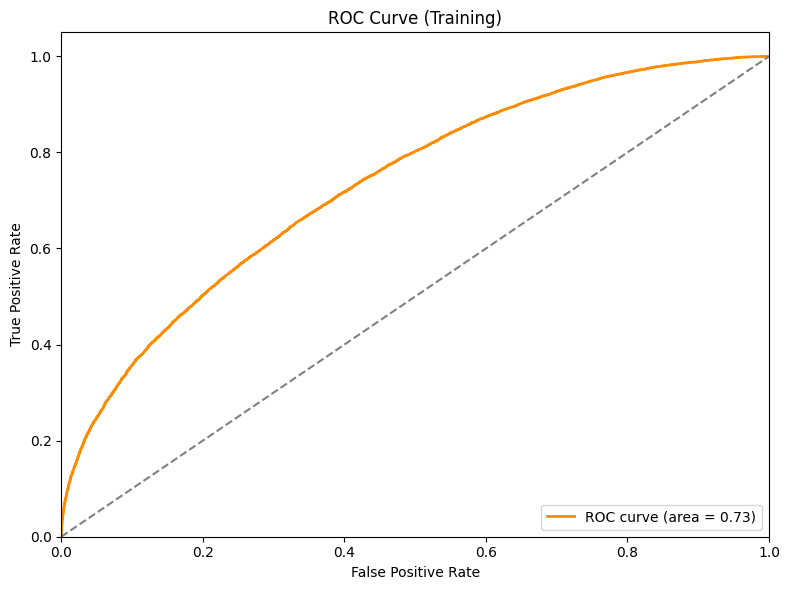

Cross-Validation Mean Squared Error: 0.2118
Cross-Validation Log Loss: 0.6098


/tmp/ipykernel_1147308/4231668488.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


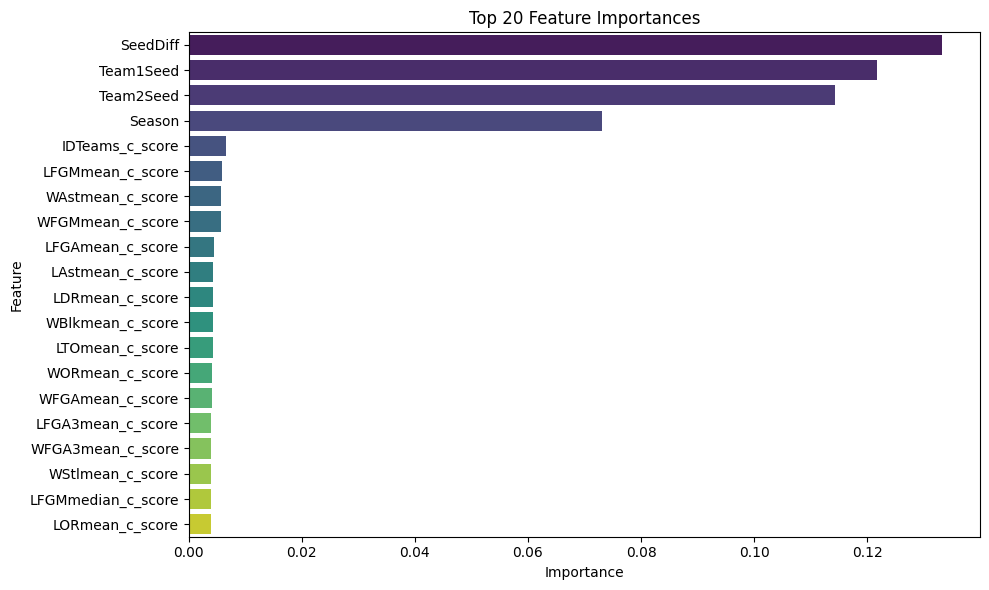

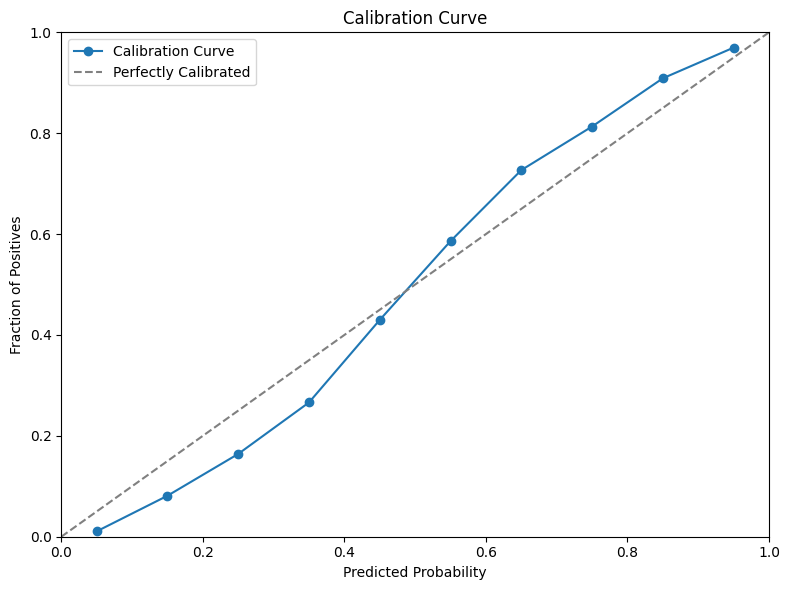

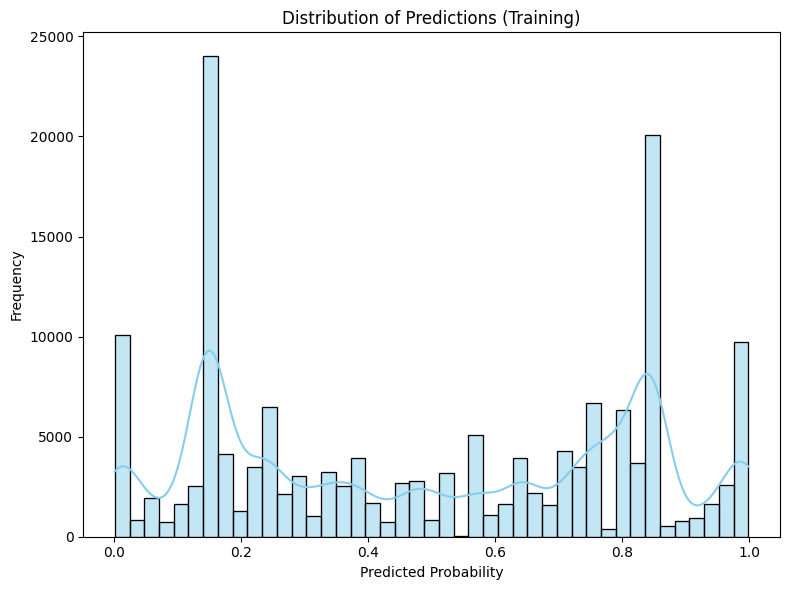

In [32]:
model_RFR, cal_model_RFR = train_model(model_RFR, X_train, X_test, y_train, y_test)

In [33]:
predict_submission(model_RFR, cal_model_RFR, sub, sub_name='submission_RFR.csv')

Submission file saved to submission_RFR.csv


## XGBoost Regressor

In [34]:
xgb_model = XGBRegressor(
    n_estimators=5000,      # number of trees to fit
    random_state=42,        # random seed for reproducibility
    max_depth=6,            # maximum depth of the tree
    learning_rate=0.03,     # step size shrinkage used to prevent overfitting
    n_jobs=-1               # use all available CPU cores
)

In [ ]:
train_model(xgb_model, X_train, X_test, y_train, y_test)